# SNF Network-based credit risk models in P2P lending markets
Goal: See whether the predictive accuracy of the ML or DL models improve when we include the centrality parameters. So its about checking the AUC values on models trained with and without the centrality measures.

Run section 1-6, and go directly to section 8.

# Libraries

## Install missing packages

In [2]:
def install_missing_packages(package_names):
    """
    Install Missing Packages

    This function checks if a list of packages is already installed and installs any missing packages using pip.

    Parameters:
    - package_names (list): A list of package names to be installed.

    Returns:
    - None

    Note: This function requires the `subprocess` and `importlib` modules to be imported.

    Example Usage:
    install_missing_packages(['h2o', 'numpy', 'pandas'])
    """
    import importlib
    import subprocess


    for package_name in package_names:
        try:
            importlib.import_module(package_name)
            print(f"{package_name} package is already installed")
        except ImportError:
            print(f"{package_name} package not found, installing with pip...")
            subprocess.call(['pip', 'install', package_name])


In [3]:
package_list = ['h2o']
install_missing_packages(package_list)

h2o package is already installed


## General packages

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import webbrowser
import pandas as pd
import shutil
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import importlib
import subprocess

import os
import hashlib

import json

## h2o models

In [54]:
"""
H2O Models

This module provides a set of utility functions for working with H2O models. H2O is an open-source machine learning platform that provides a distributed environment for building and deploying machine learning models.

Functions:
- load_model(model_path): Load an H2O model from the specified path and return the model object.
- save_model(model, model_path): Save the given H2O model to the specified path.
- predict(model, data): Generate predictions using the specified H2O model on the given data.
- evaluate(model, data): Evaluate the performance of the specified H2O model on the given data and return relevant metrics.
- get_model_details(model): Get detailed information about the specified H2O model, including its parameters and performance statistics.
- get_feature_importance(model): Get the feature importance scores for the specified H2O model, indicating the importance of each feature in the model's predictions.

Note: These functions require the H2O Python library to be installed and imported.

For more information on H2O, visit the official documentation at https://docs.h2o.ai/.
"""

import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGeneralizedLinearEstimator, H2ORandomForestEstimator, H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
import h2o.estimators.glm
from h2o.estimators import H2OXGBoostEstimator, H2OGradientBoostingEstimator

# Functions

## Read and write data

In [ ]:
def read_h2o_frame(directory, file_name):
    """
    Given a directory name and a file name, returns an H2OFrame containing the data from the file.

    Args:
        directory (str): The name of the directory to search in.
        file_name (str): The name of the file to read.

    Returns:
        H2OFrame: An H2OFrame containing the data from the file.

    Example:
        >>> directory = 'data'
        >>> file_name = 'example.txt'
        >>> data = read_h2o_frame(directory, file_name)
        >>> type(data)
        <class 'h2o.frame.H2OFrame'>
    """
    # navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())
    
    # navigate into directory
    dir_path = os.path.join(parent_dir, directory)
    
    # merge directory path with file name
    file_path = os.path.join(dir_path, file_name)
    
    # import file using h2o
    data = h2o.import_file(file_path)
    
    return data


In [ ]:
def write_df_to_disk(dataframe, directory, filename, parameters):
    """
    Given a Pandas DataFrame, a directory name, a file name, and a list of parameters,
    writes the DataFrame to a file with a name that includes the parameters and returns the full path to the file.

    Args:
        dataframe (pandas.DataFrame): The DataFrame to write to disk.
        directory (str): The name of the directory to write the file in.
        filename (str): The name of the file to write.
        parameters (list): A list of parameters to include in the filename.

    Returns:
        str: The full path to the file that was written.

    Example:
        >>> df = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
        >>> directory = 'data'
        >>> filename = 'example.csv'
        >>> parameters = ['param1', 'param2']
        >>> file_path = write_df_to_disk(df, directory, filename, parameters)
        >>> df_loaded = pd.read_csv(file_path)
        >>> pd.testing.assert_frame_equal(df, df_loaded)
    """
    # navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())
    
    # navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # create directory if it does not exist
    os.makedirs(dir_path, exist_ok=True)
    
    # merge directory path with file name
    file_path = os.path.join(dir_path, parameters+"_"+ filename)
    
    # write dataframe to file
    dataframe.to_csv(file_path, index=False)
    
    return file_path

def test_write_df_to_disk():
    # create example dataframe
    df = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
    
    # write dataframe to disk
    directory = 'data'
    filename = 'example.csv'
    parameters = str('param1'+ 'param2')
    file_path = write_df_to_disk(df, directory, filename, parameters)
    
    # load dataframe from file
    df_loaded = pd.read_csv(file_path)
    
    # check that data before and after writing to disk are the same
    pd.testing.assert_frame_equal(df, df_loaded)
    print("Test finished successfully")

test_write_df_to_disk()

In [46]:
def write_list_to_disk(lst, directory, filename, parameters):
    """
    Given a list, a directory name, a file name, and a list of parameters,
    writes the list to a file with a name that includes the parameters and returns the full path to the file.

    Args:
        lst (list): The list to write to disk.
        directory (str): The name of the directory to write the file in.
        filename (str): The name of the file to write.
        parameters (list): A list of parameters to include in the filename.

    Returns:
        str: The full path to the file that was written.
    """
    # Navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())

    # Navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # Create directory if it does not exist
    os.makedirs(dir_path, exist_ok=True)

    # Merge directory path with file name, including parameters in the file name
    file_path = os.path.join(dir_path, "_".join(parameters) + "_" + filename)

    # Write the list to a file
    with open(file_path, 'w') as f:
        for item in lst:
            f.write(f"{item}\n")

    return file_path


In [26]:
def read_df_from_disk(directory, filename, parameters):
    """
    Given a directory name, a file name, and a list of parameters,
    reads the data from the file with the specified name and returns it as a Pandas DataFrame.

    Args:
        directory (str): The name of the directory to read the file from.
        filename (str): The name of the file to read.
        parameters (list): A list of parameters that were included in the filename.

    Returns:
        pandas.DataFrame: The data from the file as a Pandas DataFrame.

    Example:
        >>> directory = 'data'
        >>> filename = 'param1_param2_example.csv'
        >>> parameters = ['param1', 'param2']
        >>> df = read_df_from_disk(directory, filename, parameters)
    """
    # navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())
    
    # navigate into directory
    dir_path = os.path.join(parent_dir, directory)
    
    # merge directory path with file name
    file_path = os.path.join(dir_path, parameters + "_" + filename)
    
    # read dataframe from file
    dataframe = pd.read_csv(file_path)
    
    return dataframe


In [5]:
def read_list_from_disk(directory, filename, parameters):
    """
    Given a directory name, a file name, and a list of parameters,
    reads the data from the file with the specified name and returns it as a list.

    Args:
        directory (str): The name of the directory to read the file from.
        filename (str): The name of the file to read.
        parameters (list): A list of parameters that were included in the filename.

    Returns:
        list: The data from the file as a list.

    Example:
        >>> directory = 'data'
        >>> filename = 'param1_param2_example.txt'
        >>> parameters = ['param1', 'param2']
        >>> lst = read_list_from_disk(directory, filename, parameters)
    """
    # Navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())

    # Navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # Merge directory path with file name, including parameters in the file name
    file_path = os.path.join(dir_path, "_".join(parameters) + "_" + filename)

    # Read list from file
    with open(file_path, 'r') as f:
        lst = [line.strip() for line in f]

    return lst


In [6]:
def calculate_hash(string):
    """Calculate SHA-256 hash of a given string"""
    hash_object = hashlib.sha256(string.encode())
    hex_dig = hash_object.hexdigest()
    return hex_dig
hash_result = calculate_hash("hello world")
print(hash_result)
# Output:  b94d27b9934d3e08a52e52d7da7dabfac484efe37a5380ee9088f7ace2efcde9


b94d27b9934d3e08a52e52d7da7dabfac484efe37a5380ee9088f7ace2efcde9


## H20 
related functions

In [7]:
def pandas_to_h2o(data):
    # Convert Pandas DataFrame to H2OFrame
    h2o_df = h2o.H2OFrame(data)
    return h2o_df

def h2o_to_pandas(h2o_df):
    # Convert H2OFrame to Pandas DataFrame
    pandas_df = h2o_df.as_data_frame()

    return pandas_df

In [8]:
def identify_binary_continuous_columns(data: pd.DataFrame, target_column: str) -> tuple:
    """
    Identify binary and continuous columns in a Pandas DataFrame.

    Parameters:
    data (pandas.DataFrame): The input Pandas DataFrame.
    target_column (str): The name of the target column.

    Returns:
    tuple: A tuple of two lists containing the binary and continuous columns, respectively.

    """
    binary_columns = []
    continuous_columns = []

    for column in data.columns:
        if column != target_column:
            unique_values = len(data[column].unique())
            if unique_values == 2:
                binary_columns.append(column)
            else:
                continuous_columns.append(column)

    return binary_columns, continuous_columns


In [9]:
def convert_binary_to_categorical(data, binary_columns):
    """
    Convert binary columns in a DataFrame to categorical data type.

    :param data: A pandas DataFrame containing the data.
    :param binary_columns: A list of column names that are binary.
    :return: A new pandas DataFrame with binary columns converted to categorical data type.
    """
    data_categorical = data.copy()

    for column in binary_columns:
        data_categorical[column] = data_categorical[column].astype('category')

    return data_categorical

In [10]:
def convert_to_h2o_frame(pandas_data,binary_columns):
    """
    Convert a pandas DataFrame or Series to an H2O Frame, preserving categorical columns.

    :param pandas_data: pandas DataFrame or Series to be converted
    :return: Converted H2O Frame
    """

    # Convert pandas Series to DataFrame
    if isinstance(pandas_data, pd.Series):
        pandas_data = pandas_data.to_frame()

    # Convert pandas DataFrame to H2O Frame
    h2o_frame = h2o.H2OFrame(pandas_data)

    # Set factor levels for categorical columns in the H2O Frame
    for column in h2o_frame.columns:
        if column in binary_columns:
            h2o_frame[column] = h2o_frame[column].asfactor()

    return h2o_frame

In [11]:
def exclude_columns(data: pd.DataFrame, exclude_list: list) -> pd.DataFrame:
    """
    Exclude specified columns from a Pandas DataFrame.

    Parameters:
    data (pandas.DataFrame): The input Pandas DataFrame.
    exclude_list (list): The list of column names to exclude.

    Returns:
    pandas.DataFrame: A new DataFrame with the specified columns removed.

    """
    new_data = data.drop(exclude_list, axis=1)

    return new_data

In [12]:
def binary_classification_metrics(y_true, y_pred):
    """
    Calculate and print binary classification metrics: accuracy, confusion matrix, and classification report.
    
    :param y_true: A pandas DataFrame or Series containing the true target values.
    :param y_pred: A pandas DataFrame or Series containing the predicted target values.
    :return: A dictionary containing the calculated classification metrics.
    """
    # Calculate classification metrics
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    metrics['classification_report'] = classification_report(y_true, y_pred)
    
    # Print the classification metrics
    print('Accuracy:', metrics['accuracy'])
    print('Confusion Matrix:\n', metrics['confusion_matrix'])
    print('Classification Report:\n', metrics['classification_report'])

    return metrics


In [13]:
def evaluate_predictions(y_true,
                         y_pred,
                         positive_class=1,
                         roc_file='roc_plot.html',
                         pr_file='pr_plot.html'):
    """
    Evaluate classification metrics, plot ROC curve and Precision-Recall curve using Plotly, and save plots as HTML files.

    :param y_true: A pandas DataFrame or Series containing the true target values.
    :param y_pred: A pandas DataFrame or Series containing the predicted target values.
    :param positive_class: The label of the positive class (default: 1).
    :param roc_file: The name of the HTML file to save the ROC curve plot (default: 'roc_plot.html').
    :param pr_file: The name of the HTML file to save the Precision-Recall curve plot (default: 'pr_plot.html').
    :return: A dictionary containing various classification metrics.
    """
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=positive_class)
    metrics['auc'] = auc(fpr, tpr)

    # Calculate Precision-Recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_true,
                                                  y_pred,
                                                  pos_label=positive_class)
    metrics['average_precision'] = average_precision_score(y_true, y_pred)

    # Create ROC curve plot
    fig_roc = make_subplots(rows=1, cols=1, subplot_titles=('ROC Curve', ))
    fig_roc.add_trace(go.Scatter(x=fpr,
                                 y=tpr,
                                 mode='lines',
                                 name='ROC Curve',
                                 line=dict(color='blue')),
                      row=1,
                      col=1)
    fig_roc.add_trace(go.Scatter(x=[0, 1],
                                 y=[0, 1],
                                 mode='lines',
                                 name='Random',
                                 line=dict(color='black', dash='dash')),
                      row=1,
                      col=1)
    fig_roc.update_layout(title=f'ROC Curve (AUC = {metrics["auc"]:.4f})',
                          xaxis_title='False Positive Rate',
                          yaxis_title='True Positive Rate',
                          showlegend=True,
                          legend=dict(orientation='h',
                                      yanchor='bottom',
                                      xanchor='right',
                                      y=1.02,
                                      x=1))

    # Save the ROC curve plot as an HTML file
    pio.write_html(fig_roc, file=roc_file)

    # Create Precision-Recall curve plot
    fig_pr = make_subplots(rows=1,
                           cols=1,
                           subplot_titles=('Precision-Recall Curve', ))
    fig_pr.add_trace(go.Scatter(x=recall,
                                y=precision,
                                mode='lines',
                                name='Precision-Recall Curve',
                                line=dict(color='blue')),
                     row=1,
                     col=1)
    fig_pr.update_layout(
        title=
        f'Precision-Recall Curve (Avg. Precision = {metrics["average_precision"]:.4f})',
        xaxis_title='Recall',
        yaxis_title='Precision',
        showlegend=True,
        legend=dict(orientation='h',
                    yanchor='bottom',
                    xanchor='right',
                    y=1.02,
                    x=1))

    # Save the Precision-Recall curve plot as an HTML file
    pio.write_html(fig_pr, file=pr_file)

    # Print classification metrics nicely

    print(f'AUC: {metrics["auc"]:.4f}')
    print(f'Average Precision: {metrics["average_precision"]:.4f}')

    # Open the HTML files in the default web browser
    webbrowser.open(roc_file)
    webbrowser.open(pr_file)

    return metrics

In [14]:
def save_h2o_model_to_disk(model, directory, filename, run_explanation=False, force_return=True):
    """
    Given an H2O estimator object, a directory name, and a file name,
    saves the trained model to disk using the provided file name and directory.
    If 'force_rerun' is set to True, it will delete any existing model at the 
    specified path before saving the new model. If 'run_explanation' is set to True,
    it will generate and save an explanation of the model.

    Args:
        model (H2OEstimator): The H2O estimator object to save.
        directory (str): The name of the directory to save the model in.
        filename (str): The name of the file to save the model in.
        run_explanation (bool, optional): Whether to generate and save an explanation 
            of the model. Defaults to False.
        force_rerun (bool, optional): Whether to delete any existing model at the 
            specified path before saving the new model. Defaults to True.

    Returns:
        str: The full path to the saved model.

    Example:
        >>> model = h2o.estimators.random_forest.H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10, seed=42)
        >>> data = h2o.import_file('example.csv')
        >>> predictors = ['a', 'b']
        >>> response = 'c'
        >>> model.train(x=predictors, y=response, training_frame=data)
        >>> directory = 'models'
        >>> filename = 'rf_model'
        >>> saved_model_path = save_h2o_model_to_disk(model, directory, filename)
        >>> loaded_model = h2o.load_model(saved_model_path)
    """
    # navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())

    # navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # create directory if it does not exist
    os.makedirs(dir_path, exist_ok=True)

    # merge directory path with file name
    file_path = os.path.join(dir_path, filename)


    if force_return and os.path.exists(file_path):
        shutil.rmtree(file_path)
    # save model to file
    #model.save_model(file_path)
    h2o.save_model(model, file_path)
    
    if(run_explanation):
        explanation = h2o.explain(model, frame=None, figsize=(12, 8), render=False)
        
    return file_path


In [15]:
def save_h2o_explanation_to_disk(explanation, directory, model_filename, explanation_filename):
    """
    Given an H2O estimator object, a directory name, and file names for the model and explanation,
    saves the trained model and its explanation to disk using the provided file names and directory.

    Args:
        model (H2OEstimator): The H2O estimator object to save.
        directory (str): The name of the directory to save the model and explanation in.
        model_filename (str): The name of the file to save the model in.
        explanation_filename (str): The name of the file to save the explanation in.

    Returns:
        tuple: The full paths to the saved model and explanation.

    Example:
        >>> model = h2o.estimators.random_forest.H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10, seed=42)
        >>> data = h2o.import_file('example.csv')
        >>> predictors = ['a', 'b']
        >>> response = 'c'
        >>> model.train(x=predictors, y=response, training_frame=data)
        >>> directory = 'models'
        >>> model_filename = 'rf_model'
        >>> explanation_filename = 'rf_explanation.html'
        >>> saved_model_path, saved_explanation_path = save_h2o_model_and_explanation_to_disk(model, directory, model_filename, explanation_filename)
        >>> loaded_model = h2o.load_model(saved_model_path)
    """
    # navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())

    # navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # create directory if it does not exist
    os.makedirs(dir_path, exist_ok=True)

    # merge directory path with file names
    model_file_path = os.path.join(dir_path, model_filename)
    explanation_file_path = os.path.join(dir_path, explanation_filename)

    with open(explanation_file_path, 'w') as f:
        f.write(explanation)

    # save explanation plots to files
    for i, item in enumerate(explanation):
        if isinstance(item, plt.Figure):
            item.savefig(os.path.join(explanation_file_path, f"plot_{i}.png"))
            plt.close(item)

    return model_file_path, explanation_file_path


## Model training and saving

In [16]:
import os

def generate_file_path(file_name):
    """
    Generate a file path for a file located one directory level up.

    Parameters:
    file_name (str): The name of the file including any subdirectories from the parent directory.

    Returns:
    file_path (str): The full path to the file.
    """
    # Get the current working directory
    cwd = os.getcwd()

    # Get the parent directory
    parent_dir = os.path.dirname(cwd)

    # Define the file path by joining the parent directory path with the file name
    file_path = os.path.join(parent_dir, file_name)

    return file_path


In [17]:
import itertools


def model_training_and_saving(X_train,
                              X_val,
                              y_train,
                              y_val,
                              exclude_LIST,
                              models_and_hyperparams,
                              model_to_train,
                              model_directory,
                              run_explanation,
                              output_filepath=None,
                              print_training_info=False,
                              force_return=True):
    """
    Train models specified in 'models_and_hyperparams' using H2O Grid Search with given training data.
    Save the trained model to disk. If 'force_rerun' is set to True, it will delete any existing 
    model before retraining and saving the new model. If 'run_explanation' is set to True, it will
    generate and save an explanation of the model.

    Args:
        X_train (DataFrame): The training data to use for model training.
        exclude_list (list): List of feature names to be excluded from the training.
        y_train (DataFrame): The target variables for model training.
        data_set_parameters (str): Information that uniquely describes the dataset.
        models_and_hyperparams (list of dict): List of dictionaries, where each dictionary contains 
            information about a model and its hyperparameters to be trained.
        model_to_train (str): Model to be trained this time.
        model_directory (str): The directory where the trained model will be saved.
        run_explanation (bool, optional): Whether to generate and save an explanation of the model. Defaults to False.
        force_rerun (bool, optional): Whether to delete any existing model before retraining and saving the new model. Defaults to True.

    Returns:
        None
    """
    if output_filepath and isinstance(output_filepath, str):
        output_directory = os.path.dirname(output_filepath)  # 获取输出文件所在的目录路径

        # 如果目录不存在，则创建它
        if output_directory and not os.path.exists(output_directory):
            os.makedirs(output_directory)

        try:
            output_file = open(output_filepath, 'w')

        except FileNotFoundError:
            output_file = open(output_filepath, 'w')

    else:
        output_file = output_filepath  # 直接使用提供的文件对象

    # 为每个模型和超参数组合执行Grid Search
    for model_info in models_and_hyperparams:  ##loop: model type
        modelName = model_info['model']

        if model_mapping[modelName] not in model_to_train:
            continue  # the model has parameters but you do not want to train it this time

        seen = set(
        )  #To avoid repeated exclude_list. They are necessary in follwing code, but should be avoided here.

        #print some info
        print(f'Model info: {model_info}\n', file=output_file)  # 打印模型信息

        for exclude_list in exclude_LIST:  ##loop: train set

            print(str(sorted(exclude_list)) + '\n', file=output_file)

            model = model_info['model']

            #if this exclude_list has been trained, escape it
            exclude_list_tuple = tuple(exclude_list)
            if exclude_list_tuple in seen:
                continue
            else:
                seen.add(exclude_list_tuple)

            #predictors
            included_features = [
                col for col in X_train.columns if col not in exclude_list
            ]

            model_name = model_info['model_name']

            # 初始化Grid Search
            params = model_info.get('params', {})
            hyper_params = model_info['hyper_params']

            grid = H2OGridSearch(model=model(**params),
                                 hyper_params=hyper_params,
                                 search_criteria={"strategy": "Cartesian"})
            # 训练多个模型
            grid.train(x=included_features,
                       y=y_train.columns,
                       training_frame=X_train.cbind(y_train),
                       validation_frame=X_val.cbind(y_val))  # 使用验证集

            # 获取Grid Search结果
            grid_results = grid.get_grid()

            keys, values = zip(*hyper_params.items())
            hyper_param_combinations = [
                dict(zip(keys, v)) for v in itertools.product(*values)
            ]

            metric_table = grid_results.sorted_metric_table()

            best_auc = 0  # 初始化最优AUC值
            best_hyper_params = None  # 初始化最优超参数
            best_model_id = None  #model id for the best model under same exclude_liat

            for i, hyper_param in enumerate(
                    hyper_param_combinations):  #loop: para

                indices = list(range(len(metric_table)))
                for key in list(hyper_param.keys()):
                    indices_new = [
                        i for i, value in enumerate(metric_table[key].tolist())
                        if (str(value) == str(hyper_param[key])
                            or value == str(hyper_param[key]) or str(value) ==
                            hyper_param[key] or value == hyper_param[key])
                    ]
                    indices = [
                        value for value in indices_new if value in indices
                    ]

                model_id = metric_table['model_ids'].tolist()[indices[0]]
                model = h2o.get_model(model_id)
                model_to_save = h2o.get_model(model_id)

                # 获取模型在验证集上的AUC
                model_perf = model.model_performance(X_val.cbind(y_val))
                model_auc = model_perf.auc()

                data_set_parameters = str(
                    sorted(exclude_list)
                ) + data_directory + preprocessed_filename + file_name
                # for saving trained model to disk. # those are the parameters that uniquely describe the dataset
                model_parameters = data_set_parameters + model_name + str(
                    hyper_param)  #
                model_parameters_hash = calculate_hash(model_parameters)

                model_to_save.model_id = model_parameters_hash

                save_h2o_model_to_disk(model=model_to_save,
                                       directory=model_directory,
                                       filename=model_parameters_hash,
                                       force_return=force_return)

                if model_auc > best_auc:
                    best_auc = model_auc
                    best_hyper_params = hyper_param
                    best_model_id = model_to_save.model_id

                # print some information
                if print_training_info:
                    print(
                        f'model_parameters: {model_parameters} model_parameters_hash: {model_parameters_hash} trained and saved!\n model_parameters_hash: {model_parameters_hash}\n'
                    )

                if run_explanation:
                    explanation = h2o.explain(model_to_save,
                                              frame=X_train.cbind(y_train),
                                              figsize=(12, 8),
                                              render=False)
                    save_h2o_explanation_to_disk(
                        explanation=explanation,
                        directory=model_directory,
                        model_filename=model_parameters_hash,
                        explanation_filename='explain')
            print(f'Best hyper parameters: {best_hyper_params}\n',
                  file=output_file)
            print(f'Best model id: {best_model_id}\n\n',file=output_file)

    # 在打印完成后，如果输出文件是通过字符串指定的，则关闭文件
    if isinstance(output_filepath, str):
        output_file.close()

## Shuffle columns in a data frame

In [18]:
def shuffle_columns(df, columns):
    """
    This function takes a DataFrame and a list of column names, and returns a new DataFrame
    where the rows in each of the specified columns have been randomly shuffled.

    Parameters:
    df (pandas.core.frame.DataFrame): The original DataFrame.
    columns (list): A list of column names to be shuffled.

    Returns:
    pandas.core.frame.DataFrame: A new DataFrame with the specified columns shuffled.

    Raises:
    ValueError: If any of the specified column names do not exist in the DataFrame.
    """
    # First, we will check if all columns exist in the DataFrame
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column {col} does not exist in the DataFrame")

    # Create a copy of the DataFrame so that the original DataFrame remains unmodified
    df_copy = df.copy()

    # For each specified column, shuffle the rows
    for col in columns:
        df_copy[col] = df[col].sample(frac=1).reset_index(drop=True)

    return df_copy


## Functions for feature selcetion

In [19]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import h2o
import numpy as np

def plot_histogram(df, file, column=None):
    """
    For each column, plot a histogram.
    If the column is full of NaN values, print a warning and skip it.
    Save each histogram as a separate page in the PDF specified by `file`.
    Also compute and display the mean, variance, and standard deviation of each column.

    Args:
    df: h2o frame. The H2OFrame to plot from.
    file: string. The path to the output PDF file.
    column: string, optional. The column to plot. If not provided, plot all columns.
    """
    
    # Convert the H2OFrame to pandas DataFrame for plotting
    df = df.as_data_frame()

    with PdfPages(file) as pdf: # Output to PDF
        if column:  # If a column is specified, only plot this column
            cols = [column]
        else:  # If no column is specified, plot all columns
            cols = df.columns

        for col in cols:
            if df[col].isna().all(): # If column is full of NaN values, print a warning and skip it
                print(f"Warning: Column {col} only contains NaN values. Skipping...")
                continue

            plt.figure()
            df_no_nan = df[col].dropna() # Remove NaN values for calculation and plotting
            sns.histplot(df_no_nan, kde=False, bins=50) # Limit the number of bins to 50
            plt.title(f"Histogram of {col}")
            plt.xlabel(col)
            plt.ylabel('Frequency')

            # Calculate mean, variance and standard deviation, and display them on the histogram
            mean = np.mean(df_no_nan)
            var = np.var(df_no_nan)
            std = np.std(df_no_nan)
            stats_text = f"Mean: {mean:.2f}\nVariance: {var:.2f}\nStd Dev: {std:.2f}"
            plt.annotate(stats_text, xy=(0.95, 0.95), xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

            pdf.savefig()  # Save the current figure to the PDF
            plt.close()  # Close the current figure

# Example usage:
# centrality_data_path = generate_file_path("graph/Bondora_centrality_sample("+str(num_default_samples*2)+").pdf")
# plot_histogram(centrality_df, centrality_data_path)


In [20]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2



def exclude_feature(X, y):
    """
    Feature selection function. Takes an H2OFrame, X and y, and returns a list
    of features to be excluded from training.
    """

    # Convert H2OFrame to pandas DataFrame for feature selection
    X_pd = X.as_data_frame(use_pandas=True)
    y_pd = y.as_data_frame(use_pandas=True)

    # Exclude columns with all NaN values or any NaN values
    exclude_columns = [col for col in X_pd.columns if X_pd[col].isnull().all() or X_pd[col].isnull().any()]
    
    # Exclude constant or quasi-constant features
    X_no_nan = X_pd.drop(columns=exclude_columns)  # remove the NaN columns for the following steps
    constant_filter = VarianceThreshold(threshold=0.005)
    constant_filter.fit(X_no_nan)
    constant_columns = [column for column in X_no_nan.columns
                        if column not in X_no_nan.columns[constant_filter.get_support()]]
    exclude_columns.extend(constant_columns)

    # Exclude correlated features
    correlated_features = set()
    correlation_matrix = X_no_nan.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    exclude_columns.extend(correlated_features)

    # Feature selection using SelectKBest
    X_nonnegative = MinMaxScaler().fit_transform(X_no_nan)
    selector = SelectKBest(score_func=chi2, k=140)  # Choose k as per your requirements
    selector.fit(X_nonnegative, y_pd)
    low_score_features = [column for column in X_no_nan.columns
                          if column not in X_no_nan.columns[selector.get_support()]]
    exclude_columns.extend(low_score_features)

    return exclude_columns


# Parameters 1: Parameters for data pre-process

In [21]:
## data parameters
data_directory = "data"  # where the data is stored
preprocessed_filename = "preprocessed"  # filename we give for storing the preprocessed data, just before training

In [22]:
# filename we give for storing the preprocessed data, just before training
preprocessed_filename = "preprocessed_shuffled"  

In [23]:
directory = 'data'
file_name = 'Bondora_sample(24000)_with_centrality.csv'
parameter_string = "pandas_washes"

# Auto ML

## Init H20

In [24]:
#Import the necessary libraries and start the H2O cluster:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_371"; Java(TM) SE Runtime Environment (build 1.8.0_371-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.371-b11, mixed mode)
  Starting server from /Users/yil1/opt/anaconda3/envs/P2P/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/p7/yz9l_v5n4cx5x7hgbnl67by40000gn/T/tmp2vc9d9ja
  JVM stdout: /var/folders/p7/yz9l_v5n4cx5x7hgbnl67by40000gn/T/tmp2vc9d9ja/h2o_yil1_started_from_python.out
  JVM stderr: /var/folders/p7/yz9l_v5n4cx5x7hgbnl67by40000gn/T/tmp2vc9d9ja/h2o_yil1_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Zurich
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,2 months and 15 days
H2O_cluster_name:,H2O_from_python_yil1_oxaqk8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.094 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


# Data Preprocessing

## Read the data

In [30]:
# read data from file using H2O
data_all_features = read_h2o_frame(directory, file_name)
# print data type
print(type(data_all_features))  # <class 'h2o.frame.H2OFrame'>

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
<class 'h2o.frame.H2OFrame'>


In [31]:
# convert to pandas dataframe
data_all_features = h2o_to_pandas(data_all_features)
#We wash data in the pandas dataframe, then convert it back to the h2o frame

In [32]:
data_all_features.head()

,default,new,Age,Gender,Interest,MonthlyPayment,DebtToIncome,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,...,A,B,C,pagerank,betweenness,closeness,eigenvector,katz,authority,hub
0,0,1,51,0,19.33,5.284117,58.48,0,0.0,2.670,...,0,0,1,0.000023,0.0,8.902073,NaN,0.006453,0.0,2.078653e-22
1,0,1,28,0,16.23,5.241324,0.00,0,0.0,4.373,...,0,1,0,0.000023,0.0,15.976149,NaN,0.006453,0.0,2.410830e-83
2,0,0,40,0,13.34,4.438525,43.85,4,12200.0,2.938,...,0,1,0,0.000023,0.0,13.396533,NaN,0.006453,0.0,6.701703e-47
3,0,0,25,0,23.32,3.161247,7.58,2,1100.0,2.505,...,0,0,1,0.000023,0.0,7.359868,NaN,0.006453,0.0,3.883548e-67
4,0,1,50,0,18.45,4.771532,0.00,0,0.0,4.034,...,0,1,0,0.000023,0.0,26.029100,NaN,0.006453,0.0,1.762067e-95


In [33]:
data_all_features.columns

Index(['default', 'new', 'Age', 'Gender', 'Interest', 'MonthlyPayment',
       'DebtToIncome', 'NoOfPreviousLoansBeforeLoan',
       'AmountOfPreviousLoansBeforeLoan', 'time',
       ...
       'A', 'B', 'C', 'pagerank', 'betweenness', 'closeness', 'eigenvector',
       'katz', 'authority', 'hub'],
      dtype='object', length=162)

## Preprocess the data
use min max scaler.
all binary columns to categorical

### Identify binary Columns

In [34]:
# Identify the binary and continuous columns
binary_columns, continuous_columns = identify_binary_continuous_columns(data_all_features, 'default')

In [35]:
binary_columns

['new',
 'Gender',
 'Hour.0',
 'Hour.1',
 'Hour.2',
 'Hour.3',
 'Hour.4',
 'Hour.5',
 'Hour.6',
 'Hour.7',
 'Hour.8',
 'Hour.9',
 'Hour.10',
 'Hour.11',
 'Hour.12',
 'Hour.13',
 'Hour.14',
 'Hour.15',
 'Hour.16',
 'Hour.17',
 'Hour.18',
 'Hour.19',
 'Hour.20',
 'Hour.21',
 'Hour.22',
 'weekday.1',
 'weekday.2',
 'weekday.3',
 'weekday.4',
 'weekday.5',
 'weekday.6',
 'ver.3',
 'ver.4',
 'duration.06',
 'duration.09',
 'duration.12',
 'duration.18',
 'duration.24',
 'duration.36',
 'duration.48',
 'duration.60',
 'use.0',
 'use.1',
 'use.2',
 'use.3',
 'use.4',
 'use.5',
 'use.6',
 'use.7',
 'use.8',
 'educ.2',
 'educ.3',
 'educ.4',
 'educ.5',
 'marital.1',
 'marital.2',
 'marital.3',
 'marital.4',
 'marital.5',
 'depen.0',
 'depen.1',
 'depen.2',
 'depen.3',
 'depen.4',
 'employ.2',
 'employ.3',
 'employ.4',
 'employ.5',
 'employ.6',
 'em.dur.other',
 'em.dur.ret',
 'em.dur.trial',
 'em.dur.1y',
 'em.dur.2y',
 'em.dur.3y',
 'em.dur.4y',
 'em.dur.5y',
 'exper.02y',
 'exper.05y',
 'exper

In [36]:
len(binary_columns)

134

In [37]:
len(continuous_columns)

27

In [38]:
len(binary_columns)+len(continuous_columns)

161

In [39]:
len(data_all_features.columns)

162

In [40]:
data_all_features[binary_columns].head(8)

,new,Gender,Hour.0,Hour.1,Hour.2,Hour.3,Hour.4,Hour.5,Hour.6,Hour.7,...,no.previous.loan.03,no.previous.loan.04,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,no.previous.repay.00,no.previous.repay.01,A,B,C
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
6,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [41]:
data_all_features[continuous_columns].head(8)

,Age,Interest,MonthlyPayment,DebtToIncome,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,log.amount,inc.princ.empl.l,inc.pension.l,...,inc.support,FreeCash.l,previous.repay.l,pagerank,betweenness,closeness,eigenvector,katz,authority,hub
0,51,19.33,5.284117,58.48,0,0.0,2.670,8.221479,6.566672,0.0,...,0.00000,3.824721,0.000000,0.000023,0.0,8.902073,NaN,0.006453,0.0,2.078653e-22
1,28,16.23,5.241324,0.00,0,0.0,4.373,8.840870,0.000000,0.0,...,0.00000,0.000000,0.000000,0.000023,0.0,15.976149,NaN,0.006453,0.0,2.410830e-83
2,40,13.34,4.438525,43.85,4,12200.0,2.938,8.066208,6.692084,0.0,...,0.05848,5.416278,0.000000,0.000023,0.0,13.396533,NaN,0.006453,0.0,6.701703e-47
3,25,23.32,3.161247,7.58,2,1100.0,2.505,6.606650,6.803505,0.0,...,0.00000,6.423815,6.398595,0.000023,0.0,7.359868,NaN,0.006453,0.0,3.883548e-67
4,50,18.45,4.771532,0.00,0,0.0,4.034,6.862758,0.000000,0.0,...,0.00000,0.000000,0.000000,0.000023,0.0,26.029100,NaN,0.006453,0.0,1.762067e-95
5,42,17.37,2.899221,0.00,6,5275.0,3.102,6.272877,0.000000,0.0,...,0.00000,0.000000,0.000000,0.000023,0.0,13.300762,NaN,0.006453,0.0,4.723409e-92
6,39,10.17,5.250387,0.00,3,4455.0,3.033,8.578288,0.000000,0.0,...,0.00000,0.000000,0.000000,0.000023,0.0,23.901119,NaN,0.006453,0.0,4.147977e-59
7,29,15.44,2.724580,0.00,5,4135.0,4.397,6.274762,0.000000,0.0,...,0.00000,0.000000,0.000000,0.000023,0.0,22.491077,NaN,0.006453,0.0,2.074464e-107


### Convert binary to categorical

In [42]:
# Use the convert_binary_to_categorical function
data_categorical = convert_binary_to_categorical(data_all_features, binary_columns)

In [43]:
data_categorical[binary_columns[0]]

0        1
1        1
2        0
3        0
4        1
        ..
23995    0
23996    1
23997    1
23998    0
23999    0
Name: new, Length: 24000, dtype: category
Categories (2, int64): [0, 1]

### Scale features

In [44]:
scaler = MinMaxScaler()
# Fit the scaler to the continuous features in the entire dataset
data_categorical[continuous_columns] = scaler.fit_transform(data_categorical[continuous_columns])

/Users/yil1/opt/anaconda3/envs/P2P/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/yil1/opt/anaconda3/envs/P2P/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [45]:
# compute min and max for each column
for column in continuous_columns:
    min_value = data_categorical[column].min()
    max_value = data_categorical[column].max()
    print(f"{column}: min = {min_value}, max = {max_value}")

Age: min = 0.0, max = 1.0
Interest: min = 0.0, max = 1.0
MonthlyPayment: min = 0.0, max = 1.0
DebtToIncome: min = 0.0, max = 0.9999999999999999
NoOfPreviousLoansBeforeLoan: min = 0.0, max = 1.0
AmountOfPreviousLoansBeforeLoan: min = 0.0, max = 1.0
time: min = 0.0, max = 1.0
log.amount: min = 0.0, max = 1.0000000000000002
inc.princ.empl.l: min = 0.0, max = 1.0
inc.pension.l: min = 0.0, max = 0.9999999999999999
inc.fam.all.l: min = 0.0, max = 1.0
inc.soc.wel.l: min = 0.0, max = 1.0
inc.leave.l: min = 0.0, max = 1.0
inc.child.l: min = 0.0, max = 1.0
inc.other.l: min = 0.0, max = 1.0
inc.total: min = 0.0, max = 1.0
liab.l: min = 0.0, max = 1.0
inc.support: min = 0.0, max = 1.0
FreeCash.l: min = 0.0, max = 1.0
previous.repay.l: min = 0.0, max = 1.0
pagerank: min = 0.0, max = 0.9999999999999999
betweenness: min = 0.0, max = 0.9999999999999999
closeness: min = 0.0, max = 1.0
eigenvector: min = nan, max = nan
katz: min = 0.0, max = 1.0
authority: min = 0.0, max = 1.0
hub: min = 0.0, max = 1.0


## Set the target and feature columns

In [46]:
# Set the target and feature columns:
target_column = "default"
feature_columns = [col for col in data_categorical.columns if col != target_column]
feature_columns
#target_column: y
#feature_columns: X

['new',
 'Age',
 'Gender',
 'Interest',
 'MonthlyPayment',
 'DebtToIncome',
 'NoOfPreviousLoansBeforeLoan',
 'AmountOfPreviousLoansBeforeLoan',
 'time',
 'Hour.0',
 'Hour.1',
 'Hour.2',
 'Hour.3',
 'Hour.4',
 'Hour.5',
 'Hour.6',
 'Hour.7',
 'Hour.8',
 'Hour.9',
 'Hour.10',
 'Hour.11',
 'Hour.12',
 'Hour.13',
 'Hour.14',
 'Hour.15',
 'Hour.16',
 'Hour.17',
 'Hour.18',
 'Hour.19',
 'Hour.20',
 'Hour.21',
 'Hour.22',
 'weekday.1',
 'weekday.2',
 'weekday.3',
 'weekday.4',
 'weekday.5',
 'weekday.6',
 'ver.3',
 'ver.4',
 'log.amount',
 'duration.06',
 'duration.09',
 'duration.12',
 'duration.18',
 'duration.24',
 'duration.36',
 'duration.48',
 'duration.60',
 'use.0',
 'use.1',
 'use.2',
 'use.3',
 'use.4',
 'use.5',
 'use.6',
 'use.7',
 'use.8',
 'educ.2',
 'educ.3',
 'educ.4',
 'educ.5',
 'marital.1',
 'marital.2',
 'marital.3',
 'marital.4',
 'marital.5',
 'depen.0',
 'depen.1',
 'depen.2',
 'depen.3',
 'depen.4',
 'employ.2',
 'employ.3',
 'employ.4',
 'employ.5',
 'employ.6',
 'em.

## Write the preprocessed data (pandas data frame) to disk

In [47]:
write_df_to_disk(data_categorical,
                 directory=data_directory,
                 filename=preprocessed_filename,
                 parameters=parameter_string)

'/Users/yil1/GitHub/P2P-Model-Bondora/data/pandas_washes_preprocessed_shuffled'

In [45]:
write_list_to_disk(lst = binary_columns, 
                   directory = data_directory, 
                   filename = preprocessed_filename, 
                   parameters = "binary columns")

NameError: name 'write_list_to_disk' is not defined

In previous section, we have:
1. data_categorical: a pandas.core.frame.DataFrame, [5 rows x 162 columns] All binary columns converted to binary varibals, all continuous columns ranged to [0, 1];

## Add robustness check columns

### Generate necessary columns

In [49]:
type(data_categorical)

pandas.core.frame.DataFrame

In [50]:
# last 7 columns
shuffled_df = data_categorical.iloc[:, -7:].apply(np.random.permutation)

# name
shuffled_df.columns = [f"{col}_shuffled" for col in shuffled_df.columns]

In [51]:
shuffled_df

,pagerank_shuffled,betweenness_shuffled,closeness_shuffled,eigenvector_shuffled,katz_shuffled,authority_shuffled,hub_shuffled
0,0.000000,0.000000,0.025951,NaN,0.000000,6.322362e-126,3.894498e-44
1,0.000000,0.048387,0.001409,NaN,0.000000,0.000000e+00,6.912055e-145
2,0.016790,0.000000,0.010875,NaN,0.047385,2.070558e-93,0.000000e+00
3,0.000000,0.000000,0.040460,NaN,0.018428,0.000000e+00,1.958060e-51
4,0.000000,0.000000,NaN,NaN,0.000000,0.000000e+00,1.434134e-73
...,...,...,...,...,...,...,...
23995,0.032291,0.000000,NaN,NaN,0.033967,4.330217e-90,2.214874e-123
23996,0.021081,0.000000,NaN,NaN,0.000000,0.000000e+00,7.532707e-68
23997,0.000000,0.000000,0.025636,NaN,0.053730,3.209247e-97,0.000000e+00
23998,0.000000,0.000000,NaN,NaN,0.054821,4.160623e-149,1.543706e-108


In [52]:
data_categorical.iloc[:, -7:]

,pagerank,betweenness,closeness,eigenvector,katz,authority,hub
0,0.000000,0.0,0.007806,NaN,0.000000,0.000000e+00,6.310865e-22
1,0.000000,0.0,0.018536,NaN,0.000000,0.000000e+00,7.319365e-83
2,0.000000,0.0,0.014623,NaN,0.000000,0.000000e+00,2.034661e-46
3,0.000000,0.0,0.005467,NaN,0.000000,0.000000e+00,1.179059e-66
4,0.000000,0.0,0.033785,NaN,0.000000,0.000000e+00,5.349700e-95
...,...,...,...,...,...,...,...
23995,0.308981,0.0,NaN,NaN,0.057166,6.773532e-103,0.000000e+00
23996,0.162980,0.0,NaN,NaN,0.019803,3.405339e-142,0.000000e+00
23997,0.477304,0.0,NaN,NaN,0.036727,6.427614e-126,0.000000e+00
23998,0.031333,0.0,NaN,NaN,0.022996,4.560141e-49,0.000000e+00


In [53]:
# filename we give for storing the preprocessed data, just before training
preprocessed_filename = "preprocessed_shuffled"  

In [54]:
data_categorical = pd.concat([data_categorical, shuffled_df], axis=1)

In [55]:
data_categorical.head()

,default,new,Age,Gender,Interest,MonthlyPayment,DebtToIncome,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,...,katz,authority,hub,pagerank_shuffled,betweenness_shuffled,closeness_shuffled,eigenvector_shuffled,katz_shuffled,authority_shuffled,hub_shuffled
0,0,1,0.634615,0,0.392055,0.699456,0.834713,0.000000,0.000000,0.280459,...,0.0,0.0,6.310865e-22,0.00000,0.000000,0.025951,NaN,0.000000,6.322362e-126,3.894498e-44
1,0,1,0.192308,0,0.291110,0.693792,0.000000,0.000000,0.000000,0.855214,...,0.0,0.0,7.319365e-83,0.00000,0.048387,0.001409,NaN,0.000000,0.000000e+00,6.912055e-145
2,0,0,0.423077,0,0.197004,0.587526,0.625892,0.153846,0.163233,0.370908,...,0.0,0.0,2.034661e-46,0.01679,0.000000,0.010875,NaN,0.047385,2.070558e-93,0.000000e+00
3,0,0,0.134615,0,0.521980,0.418453,0.108193,0.076923,0.014718,0.224772,...,0.0,0.0,1.179059e-66,0.00000,0.000000,0.040460,NaN,0.018428,0.000000e+00,1.958060e-51
4,0,1,0.615385,0,0.363400,0.631606,0.000000,0.000000,0.000000,0.740803,...,0.0,0.0,5.349700e-95,0.00000,0.000000,NaN,NaN,0.000000,0.000000e+00,1.434134e-73


In [56]:
write_df_to_disk(data_categorical,
                 directory=data_directory,
                 filename=preprocessed_filename,
                 parameters=parameter_string)

'/Users/yil1/GitHub/P2P-Model-Bondora/data/pandas_washes_preprocessed_shuffled'

In [57]:
write_list_to_disk(lst = binary_columns, 
                   directory = data_directory, 
                   filename = preprocessed_filename, 
                   parameters = "binary columns")

'/Users/yil1/GitHub/P2P-Model-Bondora/data/b_i_n_a_r_y_ _c_o_l_u_m_n_s_preprocessed_shuffled'

# Read back and convert

## Read back

In [31]:
data_categorical = read_df_from_disk(directory = data_directory,
                                     filename = preprocessed_filename, 
                                     parameters = parameter_string)
binary_columns = read_list_from_disk(directory = data_directory,
                                     filename = preprocessed_filename, 
                                     parameters = "binary columns")
target_column = "default"
feature_columns = [col for col in data_categorical.columns if col != target_column]
print(binary_columns)
print(len(binary_columns))

['new', 'Gender', 'Hour.0', 'Hour.1', 'Hour.2', 'Hour.3', 'Hour.4', 'Hour.5', 'Hour.6', 'Hour.7', 'Hour.8', 'Hour.9', 'Hour.10', 'Hour.11', 'Hour.12', 'Hour.13', 'Hour.14', 'Hour.15', 'Hour.16', 'Hour.17', 'Hour.18', 'Hour.19', 'Hour.20', 'Hour.21', 'Hour.22', 'weekday.1', 'weekday.2', 'weekday.3', 'weekday.4', 'weekday.5', 'weekday.6', 'ver.3', 'ver.4', 'duration.06', 'duration.09', 'duration.12', 'duration.18', 'duration.24', 'duration.36', 'duration.48', 'duration.60', 'use.0', 'use.1', 'use.2', 'use.3', 'use.4', 'use.5', 'use.6', 'use.7', 'use.8', 'educ.2', 'educ.3', 'educ.4', 'educ.5', 'marital.1', 'marital.2', 'marital.3', 'marital.4', 'marital.5', 'depen.0', 'depen.1', 'depen.2', 'depen.3', 'depen.4', 'employ.2', 'employ.3', 'employ.4', 'employ.5', 'employ.6', 'em.dur.other', 'em.dur.ret', 'em.dur.trial', 'em.dur.1y', 'em.dur.2y', 'em.dur.3y', 'em.dur.4y', 'em.dur.5y', 'exper.02y', 'exper.05y', 'exper.10y', 'exper.15y', 'exper.25y', 'exper.25p', 'Other', 'Processing', 'Energy', 

In [32]:
print(data_categorical.head())
print(type(data_categorical))
print(data_categorical.shape)

   default  new       Age  Gender  Interest  MonthlyPayment  DebtToIncome  \
0        0    1  0.634615       0  0.392055        0.699456      0.834713   
1        0    1  0.192308       0  0.291110        0.693792      0.000000   
2        0    0  0.423077       0  0.197004        0.587526      0.625892   
3        0    0  0.134615       0  0.521980        0.418453      0.108193   
4        0    1  0.615385       0  0.363400        0.631606      0.000000   

   NoOfPreviousLoansBeforeLoan  AmountOfPreviousLoansBeforeLoan      time  \
0                     0.000000                         0.000000  0.280459   
1                     0.000000                         0.000000  0.855214   
2                     0.153846                         0.163233  0.370908   
3                     0.076923                         0.014718  0.224772   
4                     0.000000                         0.000000  0.740803   

   ...  katz  authority           hub  pagerank_shuffled  \
0  ...   0.0  

## Train test split

In [33]:
X = data_categorical.drop(target_column, axis=1)
y = data_categorical[target_column]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.4,
                                                    random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=42)

In [34]:
print(X_train.shape)

(14400, 168)


In [35]:
print(X_test.shape)

(4800, 168)


In [36]:
print(X_val.shape)

(4800, 168)


In [37]:
X_train.copy().iloc[:,-15:]

,C,pagerank,betweenness,closeness,eigenvector,katz,authority,hub,pagerank_shuffled,betweenness_shuffled,closeness_shuffled,eigenvector_shuffled,katz_shuffled,authority_shuffled,hub_shuffled
8063,1,0.000000,0.0,0.032052,NaN,0.000000,0.000000e+00,1.450147e-94,0.000000,0.0,NaN,NaN,0.032320,8.897694e-77,6.282860e-93
4812,0,0.000000,0.0,0.027383,NaN,0.000000,0.000000e+00,6.836651e-95,0.072116,0.0,0.008196,NaN,0.000000,3.237512e-44,0.000000e+00
2126,1,0.000000,0.0,0.001437,NaN,0.000000,0.000000e+00,1.523836e-52,0.000000,0.0,0.018443,NaN,0.018299,5.736236e-95,3.672094e-121
20503,0,0.205827,0.0,NaN,NaN,0.076921,7.045160e-87,0.000000e+00,0.754861,0.0,0.040617,NaN,0.000000,0.000000e+00,0.000000e+00
15863,0,0.000000,0.0,0.014420,NaN,0.000000,0.000000e+00,2.493049e-61,0.025147,0.0,0.046317,NaN,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,1,0.317804,0.0,NaN,NaN,0.106411,5.334708e-83,0.000000e+00,0.118575,0.0,NaN,NaN,0.000000,1.263573e-62,2.982453e-29
5390,0,0.000000,0.0,0.035732,NaN,0.000000,0.000000e+00,2.126107e-87,0.046740,0.0,0.069236,NaN,0.019816,6.132651e-37,3.338669e-102
860,1,0.000000,0.0,0.036884,NaN,0.000000,0.000000e+00,1.096428e-58,0.000000,0.0,0.026148,NaN,0.000000,1.024834e-65,4.944755e-77
15795,1,0.069807,0.0,NaN,NaN,0.095726,6.009113e-56,0.000000e+00,0.170213,0.0,NaN,NaN,0.019335,0.000000e+00,0.000000e+00


## Convert to H20
also some simple tests

In [38]:
X_train = convert_to_h2o_frame(X_train, binary_columns)
X_test = convert_to_h2o_frame(X_test, binary_columns)
X_val = convert_to_h2o_frame(X_val, binary_columns)

y_train = convert_to_h2o_frame(y_train, 'default')
y_test = convert_to_h2o_frame(y_test, 'default')
y_val = convert_to_h2o_frame(y_val, 'default')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [39]:
print(y_test.isfactor())
print(y_train.isfactor())
print(y_val.isfactor())

[True]
[True]
[True]


In [40]:
is_categorical = X_train.isfactor()
for column, is_cat in zip(X_train.columns, is_categorical):
    print(f"Column {column} is {'categorical' if is_cat else 'not categorical'}")

Column new is categorical
Column Age is not categorical
Column Gender is categorical
Column Interest is not categorical
Column MonthlyPayment is not categorical
Column DebtToIncome is not categorical
Column NoOfPreviousLoansBeforeLoan is not categorical
Column AmountOfPreviousLoansBeforeLoan is not categorical
Column time is not categorical
Column Hour.0 is categorical
Column Hour.1 is categorical
Column Hour.2 is categorical
Column Hour.3 is categorical
Column Hour.4 is categorical
Column Hour.5 is categorical
Column Hour.6 is categorical
Column Hour.7 is categorical
Column Hour.8 is categorical
Column Hour.9 is categorical
Column Hour.10 is categorical
Column Hour.11 is categorical
Column Hour.12 is categorical
Column Hour.13 is categorical
Column Hour.14 is categorical
Column Hour.15 is categorical
Column Hour.16 is categorical
Column Hour.17 is categorical
Column Hour.18 is categorical
Column Hour.19 is categorical
Column Hour.20 is categorical
Column Hour.21 is categorical
Column 

Successfully converted!!!!

In [68]:
print(type(X_train))
print(type(X_test))
print(type(X_val))
print(type(y_train))
print(type(y_test))
print(type(y_val))

<class 'h2o.frame.H2OFrame'>
<class 'h2o.frame.H2OFrame'>
<class 'h2o.frame.H2OFrame'>
<class 'h2o.frame.H2OFrame'>
<class 'h2o.frame.H2OFrame'>
<class 'h2o.frame.H2OFrame'>


# Feature selection

## Select according to distribution

In [41]:
features_plot = generate_file_path('graph/features_plot.pdf')
print(features_plot)

/Users/yil1/p2p-model-bondora/graph/features_plot.pdf


KeyboardInterrupt: 

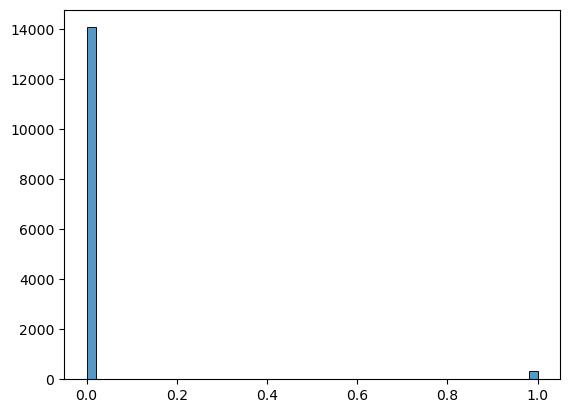

In [42]:
plot_histogram(df=X_train, file=features_plot, column=None)

In [43]:
exclude_features_distribution = [
    'inc.princ.empl.l', 'inc.pension.l', 'inc.fam.all.l', 'inc.soc.wel.l',
    'inc.leave.l', 'inc.child.l', 'inc.other.l', 'eigenvector', 'authority',
    'hub', 'eigenvector_shuffled', 'authority_shuffled', 'hub_shuffled'
]

In [47]:
write_list_to_disk(lst=exclude_features_distribution,
                   directory=data_directory,
                   filename=preprocessed_filename,
                   parameters="exclude_features_distribution")

'/Users/yil1/p2p-model-bondora/data/e_x_c_l_u_d_e___f_e_a_t_u_r_e_s___d_i_s_t_r_i_b_u_t_i_o_n_preprocessed_shuffled'

## Feature selection

In [48]:
exclude_features_selectionMethod = exclude_feature(X=X_train, y=y_train)
exclude_features_selectionMethod

['closeness',
 'eigenvector',
 'authority',
 'hub',
 'closeness_shuffled',
 'eigenvector_shuffled',
 'authority_shuffled',
 'hub_shuffled',
 'Hour.3',
 'marital.5',
 'depen.4',
 'employ.2',
 'employ.4',
 'employ.6',
 'em.dur.trial',
 'Energy',
 'Real.estate',
 'Research',
 'Administrative',
 'Art.entertainment',
 'inc.soc.wel.l',
 'inc.leave.l',
 'inc.total',
 'no.refin.04',
 'inc.support',
 'betweenness',
 'katz',
 'betweenness_shuffled',
 'katz_shuffled',
 'liab.l',
 'employ.3',
 'previous.repay.l',
 'inc.princ.empl.l',
 'FreeCash.l',
 'no.previous.repay.01',
 'no.previous.loan.00',
 'Interest',
 'AmountOfPreviousLoansBeforeLoan',
 'Hour.2',
 'Hour.9',
 'Hour.12',
 'Hour.19',
 'weekday.2',
 'weekday.4',
 'weekday.6',
 'depen.0',
 'depen.1',
 'em.dur.trial',
 'exper.10y',
 'Construction',
 'Hospitality.catering',
 'Administrative',
 'FreeCash.l',
 'no.previous.repay.00',
 'A',
 'pagerank_shuffled']

In [49]:
elements_to_remove = [
    'pagerank', 'betweenness', 'closeness', 'eigenvector', 'katz', 'authority',
    'hub', 'pagerank_shuffled', 'betweenness_shuffled', 'closeness_shuffled',
    'eigenvector_shuffled', 'katz_shuffled', 'authority_shuffled',
    'hub_shuffled'
]
exclude_features_selectionMethod = [
    feature for feature in exclude_features_selectionMethod
    if feature not in elements_to_remove
]
exclude_features_selectionMethod

['Hour.3',
 'marital.5',
 'depen.4',
 'employ.2',
 'employ.4',
 'employ.6',
 'em.dur.trial',
 'Energy',
 'Real.estate',
 'Research',
 'Administrative',
 'Art.entertainment',
 'inc.soc.wel.l',
 'inc.leave.l',
 'inc.total',
 'no.refin.04',
 'inc.support',
 'liab.l',
 'employ.3',
 'previous.repay.l',
 'inc.princ.empl.l',
 'FreeCash.l',
 'no.previous.repay.01',
 'no.previous.loan.00',
 'Interest',
 'AmountOfPreviousLoansBeforeLoan',
 'Hour.2',
 'Hour.9',
 'Hour.12',
 'Hour.19',
 'weekday.2',
 'weekday.4',
 'weekday.6',
 'depen.0',
 'depen.1',
 'em.dur.trial',
 'exper.10y',
 'Construction',
 'Hospitality.catering',
 'Administrative',
 'FreeCash.l',
 'no.previous.repay.00',
 'A']

In [50]:
write_list_to_disk(lst=exclude_features_selectionMethod,
                   directory=data_directory,
                   filename=preprocessed_filename,
                   parameters="exclude_features_selectionMethod")

'/Users/yil1/p2p-model-bondora/data/e_x_c_l_u_d_e___f_e_a_t_u_r_e_s___s_e_l_e_c_t_i_o_n_M_e_t_h_o_d_preprocessed_shuffled'

# Parameters 2: Parameters for model training

## Model directory

In [51]:
model_directory = "model"

## Define models
Add new models here.

Mapping from model to model_id.

Do not for get to import models in Section 2 at h20 models.

In [55]:
"""
Define Models and Hyperparameters

This section defines a list of models along with their corresponding hyperparameters. Each model is represented by a dictionary containing the following keys:

- 'model': The model class or constructor.
- 'model_name': A string representing the name or identifier of the model.
- 'hyper_params': A dictionary specifying the hyperparameter grid for the model.
- 'params': Additional parameters for the model.

The list 'models_and_hyperparams' contains multiple such dictionaries, each representing a different model with its hyperparameters.

After defining the list, the function 'write_list_to_disk' is called to write the 'models_and_hyperparams' list to a file on disk.

Parameters:
- None

Returns:
- None

Example Usage:
Define the models and hyperparameters, and write them to a file:
    write_list_to_disk(
        lst=models_and_hyperparams,
        directory=model_directory,
        filename="models_and_hyperparams",
        parameters=""
    )
"""

# Define Models and Hyperparameters
models_and_hyperparams = [
    # Existing models...
    {
        'model': H2OGeneralizedLinearEstimator,
        'model_name': "GLM",
        'hyper_params': {
            'alpha': [0, 0.2, 0.4, 0.6, 0.8, 1],
            'lambda': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        },
        'params': {
            'family': 'binomial'
        }
    },
    {
        'model': H2ORandomForestEstimator,
        'model_name': "RF",
        'hyper_params': {
            'ntrees': [50, 100, 150, 200, 250],
            'max_depth': [5, 10, 15, 20]
        },
        'params': {}
    },
    {
        'model': H2ODeepLearningEstimator,
        'model_name': "DL",
        'hyper_params': {
            'hidden': [[50, 50], [100, 100], [200, 200], [100, 200, 100],
                       [200, 100, 200]],
            'epochs': [10, 50, 100],
        },
        'params': {}
    },
    # New models...
    {
        'model': H2OXGBoostEstimator,
        'model_name': "XGB",
        'hyper_params': {
            'ntrees': [100, 200],
            'max_depth': [5, 15],
            'learn_rate': [0.01, 0.1, 0.2],
            'sample_rate': [0.6, 0.8, 1.0],
        },
        'params': {}
    },
    {
        'model': H2OGradientBoostingEstimator,
        'model_name': "GBM",
        'hyper_params': {
            'ntrees': [100, 200],
            'max_depth': [5, 15],
            'learn_rate': [0.01, 0.1, 0.2],
            'sample_rate': [0.6, 0.8, 1.0],
        },
        'params': {}
    }
]

This cell is not very useful because an object can hardly be saved in right format. The current method is to copy this cell 

In [56]:
# Write the models and hyperparameters to a file
write_list_to_disk(
    lst=models_and_hyperparams,
    directory=model_directory,
    filename="models_and_hyperparams",
    parameters=""
)

'/Users/yil1/p2p-model-bondora/model/_models_and_hyperparams'

In [98]:
"""
Model Mapping and Print Example

This section defines a dictionary named 'model_mapping' that maps H2O model classes to their corresponding abbreviations or names. The keys in the dictionary are the model classes (e.g., H2OGeneralizedLinearEstimator) and the values are the corresponding abbreviations or names (e.g., "GLM").

After defining the 'model_mapping' dictionary, an example print statement is used to demonstrate how to retrieve the abbreviation/name for a specific model class. In this case, the abbreviation/name for the H2OGeneralizedLinearEstimator class is retrieved and printed.

Parameters:
- None

Returns:
- None

Example Usage:
Define the 'model_mapping' dictionary and retrieve the abbreviation/name for a specific model class:
    print(model_mapping[H2OGeneralizedLinearEstimator])
"""

# Model Mapping
model_mapping = {
    H2OGeneralizedLinearEstimator: "GLM",
    H2ORandomForestEstimator: "RF",
    H2ODeepLearningEstimator: "DL",
    H2OXGBoostEstimator:"XGB",
    H2OGradientBoostingEstimator:"GBM"
}

# Example Print Statement
print(model_mapping[H2OGeneralizedLinearEstimator])


GLM


In [99]:
if not len(models_and_hyperparams) == len(model_mapping):
    print("Check your definition of models. Always keep consistent for the cells above!!!")

## Choose model
You can train only a some types of models by changing parameters here.

In [103]:
model_to_train = ["GLM",'RF',"DL"]
output_file=generate_file_path('output_info/'+str(model_to_train)+".txt")
print(output_file)

/Users/yil1/GitHub/P2P-Model-Bondora/output_info/['GLM', 'RF', 'DL'].txt


## Other parameters controling the training and saving process

In [101]:
## Training parameters
run_explanation = False # run model_explain , it is quite slow

## Parameters for X_train

In [102]:
exclude_features_distribution
exclude_features_selectionMethod

exclude_LIST = [
    #This is EXCLUDE list!!!
    #When you change this list, it must keep two dimentions, and contains only strings
    #All initial columns - uninformative features
    list(
        set([
            'pagerank', 'betweenness', 'closeness', 'eigenvector', 'katz',
            'authority', 'hub', 'pagerank_shuffled', 'betweenness_shuffled',
            'closeness_shuffled', 'eigenvector_shuffled', 'katz_shuffled',
            'authority_shuffled', 'hub_shuffled'
        ] + exclude_features_distribution + exclude_features_selectionMethod)),
    #Initial columns - uninformative features + informative graph features
    list(
        set([
            'pagerank_shuffled', 'betweenness_shuffled', 'closeness_shuffled',
            'eigenvector_shuffled', 'katz_shuffled', 'authority_shuffled',
            'hub_shuffled'
        ] + exclude_features_distribution + exclude_features_selectionMethod)),
    #All initial columns - uninformative features
    list(
        set([
            'pagerank', 'betweenness', 'closeness', 'eigenvector', 'katz',
            'authority', 'hub', 'pagerank_shuffled', 'betweenness_shuffled',
            'closeness_shuffled', 'eigenvector_shuffled', 'katz_shuffled',
            'authority_shuffled', 'hub_shuffled'
        ] + exclude_features_distribution + exclude_features_selectionMethod)),
    #Initial columns - uninformative features + shuffled  graph features
    list(
        set([
            'pagerank', 'betweenness', 'closeness', 'eigenvector', 'katz',
            'authority', 'hub'
        ] + exclude_features_distribution + exclude_features_selectionMethod))
]

Explaination on exclude list

exclude_features_distribution:\
Features in this list are excluded because their distribution (observed from histogram) are not informative. Most observations take same value on these features. So they are manually picked up and deleted.\
Features in this list are not condidered in the whole process: model training, hypermeter tuning and so on.
'eigenvector', 'authority','hub', 'eigenvector_shuffled', 'authority_shuffled', 'hub_shuffled' are in this list.

exclude_features_selectionMethod:
Features in this list are selected out by function exclude_feature(X, y). This function selects uninformative features if one feature:\
contains NaN values\
is constant or quasi-constant\
is highly correlated with another feature\
is independent to y according to the Chi-squared test.\
Features in this list are not condidered in the whole process: model training, hypermeter tuning and so on.

Then, exclude_list 1 excludes all graph features and their shuffled value.\
This means the 1st group use all informative columns in initial data set.

exclude_list 2 excludes all shuffled graph features.\
This means the 2nd group use all informative columns in initial data set, plus 4 graph features.

exclude_list 3 is the same as exclude_list 1. This group is only for robustness check purpose.

exclude_list 4 excludes all graph features.\
This means the 4th group use all informative columns in initial data set, plus 4 shuffled graph features.

# Models: Training and Saving

## Train the H20 model and save

In [107]:
model_training_and_saving(X_train=X_train,
                          X_val=X_val,
                          y_train=y_train,
                          y_val=y_val,
                          exclude_LIST=exclude_LIST,
                          models_and_hyperparams=models_and_hyperparams,
                          model_to_train=model_to_train,
                          model_directory=model_directory,
                          run_explanation=run_explanation,
                          output_filepath=output_file,
                          print_training_info=False,
                          force_return=True)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
